In [139]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from os.path import join

In [46]:
fig_dir = '/Users/zachkeskinen/Documents/infrasound/figures/writing/study_site'

In [253]:
snotel_fp = '/Users/zachkeskinen/Documents/infrasound/data/snotel/WTEQ__value,SNWD__value,PREC__value,TOBS__value,TMAX__value,TMIN__value,TAVG__value.txt'

from itertools import takewhile
with open(snotel_fp, 'r') as fobj:
    # takewhile returns an iterator over all the lines 
    # that start with the comment string
    headiter = takewhile(lambda s: s.startswith('#'), fobj)
    # you may want to process the headers differently, 
    # but here we just convert it to a list
    header = list(headiter)

In [254]:
snotel_fp = '/Users/zachkeskinen/Documents/infrasound/data/snotel/WTEQ__value,SNWD__value,PREC__value,TOBS__value,TMAX__value,TMIN__value,TAVG__value.txt'
snotel = pd.read_csv(snotel_fp, comment='#', index_col=['Date'])
for c in snotel.columns:
    snotel[c] = snotel[c].astype('f4')
snotel['Snow Water Equivalent'] = snotel['Snow Water Equivalent (mm) Start of Day Values']/1000
snotel['Snow Depth'] = snotel['Snow Depth (cm) Start of Day Values']/100
snotel['Average Air Temp'] = snotel['Air Temperature Average (degC)']

## Max SWE amount

In [255]:
snotel['Snow Water Equivalent'].max()

0.5720000267028809

## Max SWE Date

In [256]:
snotel.idxmax()['Snow Water Equivalent']

'2022-05-01'

## Corresponding snow depth at max swe

In [257]:
snotel.loc[snotel.idxmax()['Snow Water Equivalent'], 'Snow Depth']

1.32

## Plot

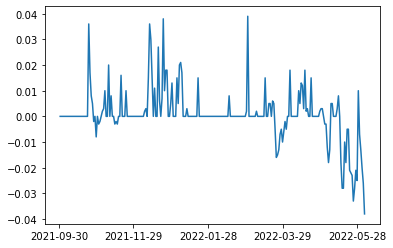

In [281]:
from matplotlib.ticker import MaxNLocator
snotel.index = pd.to_datetime(snotel.index)
a = snotel['Snow Water Equivalent'].resample('1D').mean().shift(-1) - snotel['Snow Water Equivalent'].resample('1D').mean()
plt.plot(a)
plt.xticks()
axes = plt.gca()
axes.xaxis.set_major_locator(MaxNLocator(5)) 

In [289]:
a.sort_values(ascending=False).head(10)

Date
2022-03-01    0.039
2021-12-23    0.038
2021-10-24    0.036
2021-12-12    0.036
2021-12-13    0.030
2021-12-19    0.027
2022-01-06    0.021
2021-11-09    0.020
2022-01-05    0.020
2022-04-16    0.018
Name: Snow Water Equivalent, dtype: float32

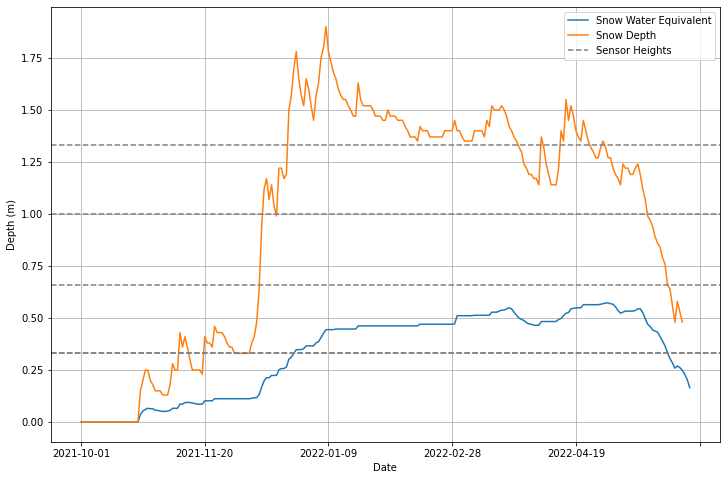

In [58]:
f, ax = plt.subplots(figsize = (12,8))
snotel[['Snow Water Equivalent','Snow Depth']].plot(ax = ax)
plt.grid()
plt.ylabel('Depth (m)')
[ax.axhline(y=i, linestyle='--', color = 'grey') for i in [0.33,0.66,1,1.33]]
ax.axhline(0.33, linestyle='--', color = 'grey', label = 'Sensor Heights')
plt.legend()
#plt.axhlines([0.33,0.66,1,1.33])
plt.savefig(join(fig_dir, 'snotel_fig.png'))

## Peak SD and date

In [49]:
snotel['Snow Depth'].max()

1.899999976158142

In [50]:
snotel.idxmax()['Snow Depth']

'2022-01-08'

## Avalanche activity index

In [335]:
daily_hwy21_obs = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/hwy21-avis/DailyObs.csv', index_col = 'obs_date_time', parse_dates = True)
daily_hwy21_obs.road_status = daily_hwy21_obs.road_status.str.lower()
daily_hwy21_obs = daily_hwy21_obs.dropna(subset = ['road_status'])
closed_road = daily_hwy21_obs.loc[daily_hwy21_obs['road_status'].str.contains("closed", case=False)]

In [397]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/hwy21-avis/2022.csv', index_col = 0, parse_dates = True)
activity_index_dic = {1: 0.01, 2: 0.1, 3:1, 4:10}
df.loc[:, 'Avalanche Activity Index'] = [activity_index_dic[i] for i in df.Size]
df.loc[:, 'Avalanche Count'] = df.size
counts = df.resample('D').count()['Avalanche Count']
counts = counts[counts>0]
aai_s = df.resample('D').sum()['Avalanche Activity Index']
aai_s = aai_s[aai_s > 0]
res = pd.concat([aai_s, counts], axis = 1)
res['Avalanche Count'] = res['Avalanche Count'].astype('i').astype('str')
new_index = []
for i, d in enumerate(res.index.date):
    d_range = []
    if d in closed_road.index.date or d - pd.Timedelta('1 day') in closed_road.index.date:
        day_list = []
        old = None
        for j in closed_road.index[closed_road.index.date <= d][::-1].date:
            if not old:
                old = j
                day_list.append(j)
            else:
                if old - pd.Timedelta('1 day') == j:
                    day_list.append(j)
                    old = j
                else:
                    if len(day_list) > 1:
                        day1 = str(day_list[-1])
                        last_day = str(day_list[0])
                        last_day = str(d)
                        n_index = f'{day1} to {last_day}'
                        new_index.append(n_index)
                        # res.index[i] = n_index
                    else:
                        new_index.append(str(d))
                    break
    else:
        new_index = str(d)
res.index = new_index

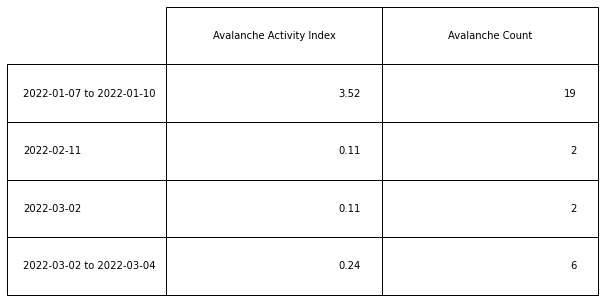

In [399]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
f = plt.figure()
ax = f.add_axes([1,1,1,1], frame_on = False)
#ax = plt.subplots(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, np.round(res,3), bbox = [0.0, 0, 1, 1])  # where df is your data frame

plt.savefig(join('/Users/zachkeskinen/Documents/infrasound/figures/signal_compares', 'aai_2022_table'))

Earthquake map/table

In [143]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/earthquakes/banner_earthquakes.csv', index_col='time', parse_dates=True)
df['coordinates'] = list(zip(df.longitude, df.latitude))
df['coordinates'] = df['coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='coordinates', crs = 'epsg:4326')
snotel_df = gpd.GeoDataFrame(pd.DataFrame({'name': ['Banner Summit'], 'geometry' : [Point([-115.240103, 44.316371])]}), geometry =  'geometry', crs = 'epsg:4326')

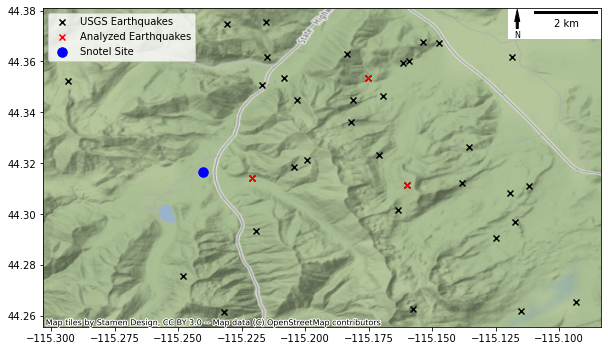

In [252]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches
ids_used = ['us7000ggx4','us7000gjaw','us6000h1ql']

ax = gdf.plot(figsize=(10, 10), alpha=1, marker = 'x', color = 'black', label = 'USGS Earthquakes')
used = gdf[gdf['id'].isin(ids_used)]
used.plot(ax = ax, marker = 'x', color ='red', label = 'Analyzed Earthquakes')
snotel_df.plot(ax = ax, marker = 'o', color = 'blue', markersize = 90, label = 'Snotel Site')
# cx.add_basemap(ax, crs=gdf.crs)
cx.add_basemap(ax, source=cx.providers.Stamen.Terrain, zoom=12, crs=gdf.crs)
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=12, crs=gdf.crs)

## Scale Bar
ref_lat = snotel_df.loc[0,'geometry'].y
points = gpd.GeoSeries([Point(-73.5, ref_lat), Point(-74.5, ref_lat)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters))

## North Arrow
x, y, arrow_length = 0.85, 0.994, 0.08
na = ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=5),
            ha='center', va='center', fontsize=8,
            xycoords=ax.transAxes)

# Create a Rectangle patch
rect = patches.Rectangle((-115.12, 44.369), 0.1, 0.1, linewidth=1, edgecolor='none', facecolor='white')
# Add the patch to the Axes
ax.add_patch(rect)

plt.legend()

plt.savefig(join('/Users/zachkeskinen/Documents/infrasound/figures/signal_compares', 'earth_map.png'))

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import contextily as cx
from os.path import join
import pickle
from shapely.geometry import Point, box
from shapely.ops import transform
import pyproj
from correlate import zero_lag_correlate
from filtering import freq_filt
from tqdm import tqdm

In [35]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

In [37]:
j = 0
n = 12
plot_n = 10
for i, r in res.iterrows():
    if r.selected == 1:
        j +=1
    if j < (n+1)*plot_n and j > n*plot_n and r.selected == 1:
        f, ax = plt.subplots(1,2, figsize = (16,4))
        s = pd.to_datetime(r.time)
        e = s + pd.Timedelta('20 seconds')
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        d['lower'] = pd.read_parquet(day[0.33])
        d['upper'] = pd.read_parquet(day[1])
        for l, k in enumerate(d.keys()):
            d[k] = d[k].loc[s:e, :].values.ravel()
            d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
            ax[l].plot(d[k])
        plt.show()
    if j > (n+1)*plot_n:
        break

import py3dep

geom = gdf.geometry.total_bounds
geom = tuple(geom)
hs = py3dep.get_map("Hillshade Gray", geom, resolution=30, geo_crs="epsg:4326", crs="epsg:4326")

states = gpd.read_file('~/scratch/data/infrasound/dem/tl_2021_us_state.shp')

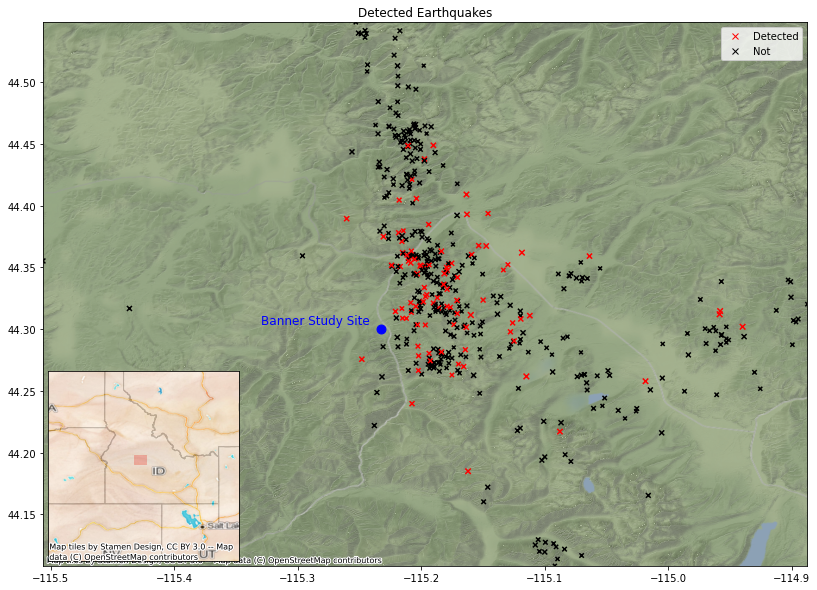

In [86]:
f, ax = plt.subplots(figsize=(16, 10))
ax2 = inset_axes(ax, "25%", "35%", loc="lower left")
ax2.set_ylim([39, 49])
ax2.set_xlim([-120, -110])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
states.plot(facecolor = 'None', ax = ax2)
# states.apply(lambda x: ax2.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='right', va = 'bottom'), axis=1);
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 1, facecolor = 'red', edgecolor = 'red')
cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.Watercolor)
cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.TonerLabels, zoom = 5)
# # Plot data
selected_dic = {1:'red',0:'black'}
cs = [selected_dic[sel] for sel in gdf.selected]
sc = ax.scatter(x = gdf.geometry.x, y = gdf.geometry.y, s=gdf.mag*10, color = cs, marker = 'x', zorder = 3)
# # Basemap and snotel

ax.annotate('Banner Study Site', (banner_coords[1], banner_coords[0]), xytext=(-120, 5), color='blue', zorder=3, textcoords='offset points', fontsize=12)

ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 80, color = 'blue', marker = 'o', zorder = 3)
cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.Stamen.Terrain, alpha = .8, zorder = 2)
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar=False)
ax.set_title('Detected Earthquakes')
# # The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='x', linestyle='') for color in selected_dic.values()]
ax.legend(markers, ['Detected', 'Not'], numpoints=1)

ax.set(xlabel = None)
ax.set(ylabel = None)
plt.show()